### Part 5: Machine Learning

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
X_ = pd.read_csv('data/features.csv', parse_dates = [1], index_col = [0, 1])
y_ = pd.read_csv('data/target.csv', parse_dates = [1], index_col = [0, 1])

In [3]:
X = X_.reset_index().sort_values(by='Date').reset_index(drop=True).set_index(['Date', 'StartStation Id'])
y = y_.reset_index().sort_values(by='Date').reset_index(drop=True).set_index(['Date', 'StartStation Id'])

In [4]:
from sklearn.model_selection import train_test_split

train_dates, test_dates = train_test_split(X.index.get_level_values(0).unique(), shuffle=False, test_size=0.3)
X_train, y_train = X.loc[train_dates], y.loc[train_dates]
X_test, y_test = X.loc[test_dates], y.loc[test_dates]

#### Benchmark Model

In [38]:
class BenchmarkModel:
    def __init__(self):
        self.y_pred = None
    
    def predict(self, X_test):
        self.y_pred = X_test['start_count_day_bf']
        return self.y_pred
    
    def score(self, X_test, y_test, scoring_func, plot_residuals=False):
        # MAPE-mean absolute percentage error
        if self.y_pred == None:
            self.y_pred = BenchmarkModel.predict(self, X_test)
        
        if plot_residuals == True:
            residuals = y_test.values.reshape(-1) - self.y_pred.values
            plt.plot(np.arange(len(y_test)), residuals, 'o', label='Residuals')
            plt.plot(np.arange(len(y_test)), np.zeros(len(y_test)), '--')
            plt.legend()
            plt.show()

        return scoring_func(y_test.values.reshape(-1), self.y_pred.values)

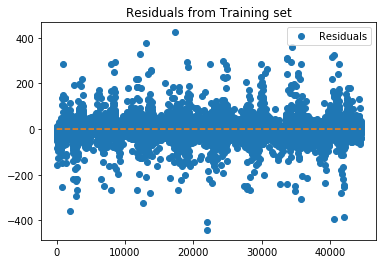

RMSE is 24.272004397096225


In [39]:
model = BenchmarkModel()
plt.title('Residuals from Training set')
print('RMSE is {}'.format(np.sqrt(model.score(X_train, y_train, mean_squared_error, plot_residuals=True))))

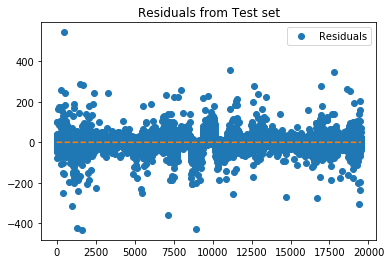

RMSE is 26.651867639164987


In [40]:
model = BenchmarkModel()
plt.title('Residuals from Test set')
print('RMSE is {}'.format(np.sqrt(model.score(X_test, y_test, mean_squared_error, plot_residuals=True))))

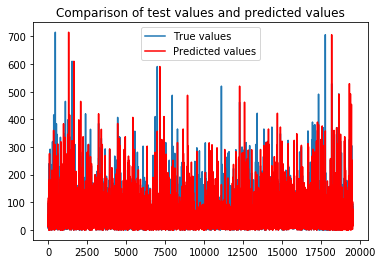

In [14]:
plt.plot(y_test.values, label='True values')
plt.plot(model.predict(X_test).values, color='r', label='Predicted values')
plt.title('Comparison of test values and predicted values')
plt.legend()
plt.show()

<b>The benchmark model gives us a RMSE of 24 on the training set and 27 on the test set. 

#### Linear Regression

In [14]:
def score(y_test, y_pred, scoring_func, plot_residuals=False):
    
    if plot_residuals == True:
            residuals = y_test - y_pred
            plt.plot(np.arange(len(y_test)), residuals, 'o', label='Residuals')
            plt.plot(np.arange(len(y_test)), np.zeros(len(y_test)), '--')
            plt.legend()
            plt.show()

    return scoring_func(y_test, y_pred)

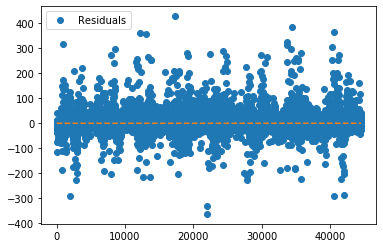

RMSE is 22.08382976518293


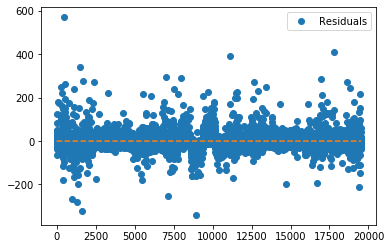

RMSE is 24.38454634008853


In [49]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
print('RMSE is {}'.format(np.sqrt(score(y_train, reg.predict(X_train), mean_squared_error, plot_residuals=True))))
print('RMSE is {}'.format(np.sqrt(score(y_test, reg.predict(X_test), mean_squared_error, plot_residuals=True))))

In [51]:
# coefficients
pd.DataFrame(reg.coef_, columns=X_test.columns)

,day_no,is_weekday,start_count_day_bf,end_count_day_bf,7d_rolling_dur,temperature,wind_speed,good_weather,ok_weather,bad_weather,very_bad_weather
0,-1.872117,-1.715196,0.391091,0.397864,0.086893,-0.381733,-0.043915,-7.397081,-10.576342,-48.983594,66.957017


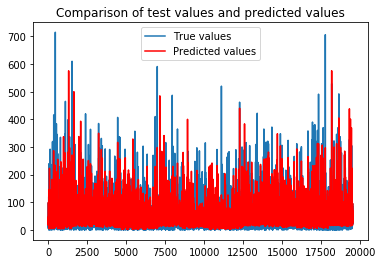

In [53]:
plt.plot(y_test.values, label='True values')
plt.plot(reg.predict(X_test), color='r', label='Predicted values')
plt.title('Comparison of test values and predicted values')
plt.legend()
plt.show()

<b>Using simple linear regression gives us a slight improvement in RMSE (22 on training set and 24 on test set). The coefficients for good weather and very bad weather don't completely make sense as the count should be lower during very bad weather (as witnessed during the data visualisation steps). We try and use ridge regression to see if we can adjust the coefficients but this also requires hyperparameter tuning. We can't use cross-validation as we need to preserve the time order to prevent any leakage of data. Here, we will use scikit-learn's TimeSeriesSplit to do hyperparameter tuning. 

#### Ridge Regression

In [15]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit

dates = X_train.index.get_level_values(0).unique()
errs = []
for alpha_val in [0.01, 0.1, 1, 10, 100, 300, 500]:
    mse_err = 0
    for train_index, test_index in TimeSeriesSplit(n_splits=5).split(dates):
        reg = Ridge(alpha=alpha_val).fit(X_train.loc[dates[train_index]], y_train.loc[dates[train_index]])
        mse_err += score(y_train.loc[dates[test_index]], reg.predict(X_train.loc[dates[test_index]]), mean_squared_error)
    errs.append(mse_err/5)

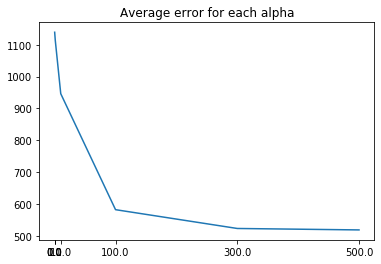

In [124]:
plt.plot([0.01, 0.1, 1, 10, 100, 300, 500], errs)
plt.xticks([0.01, 0.1, 1, 10, 100, 300, 500])
plt.title('Average error for each alpha')
plt.show()

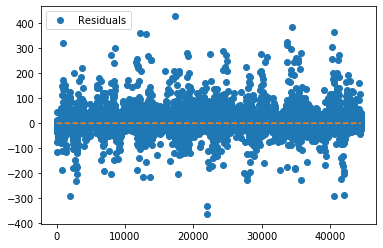

RMSE is 22.132239152556473


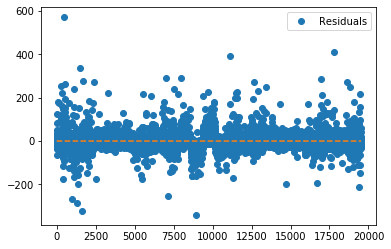

RMSE is 24.38912645758185


In [136]:
reg = Ridge(alpha=300).fit(X_train, y_train)
print('RMSE is {}'.format(np.sqrt(score(y_train, reg.predict(X_train), mean_squared_error, plot_residuals=True))))
print('RMSE is {}'.format(np.sqrt(score(y_test, reg.predict(X_test), mean_squared_error, plot_residuals=True))))

In [133]:
# coefficients
pd.DataFrame(reg.coef_, columns=X_test.columns)

,day_no,is_weekday,start_count_day_bf,end_count_day_bf,7d_rolling_dur,temperature,wind_speed,good_weather,ok_weather,bad_weather,very_bad_weather
0,-1.937238,-2.328836,0.392008,0.397778,0.087504,-0.198737,-0.004933,10.331158,4.53999,-15.62247,0.751323


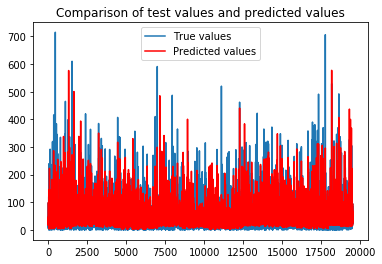

In [243]:
plt.plot(y_test.values, label='True values')
plt.plot(reg.predict(X_test), color='r', label='Predicted values')
plt.title('Comparison of test values and predicted values')
plt.legend()
plt.show()

<b>There is no improvement using Ridge regression which is not surprising given that overfitting was not the issue to begin with but at least the wearher coefficeints make more sense. We will try using a different model to see if we can get any improvements. Here, we experiment with gradient boosting, XGBoost and Adaboost. These methods are prone to overfitting, hence we will have to do some more hyperparameter tuning.

#### Gradient boosting

In [16]:
X_train_ = X_train.reset_index()

idx = []
for train_index, test_index in TimeSeriesSplit(n_splits=5).split(dates):
    train_idx = X_train_[X_train_['Date'].isin(dates[train_index])].index.tolist()
    test_idx = X_train_[X_train_['Date'].isin(dates[test_index])].index.tolist()
    idx.append((train_idx, test_idx))

In [236]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

gb_reg = GradientBoostingRegressor(loss='ls', max_features='sqrt', subsample=0.8)
param_test = {'n_estimators':range(20,81,10), 'learning_rate':[0.01, 0.05, 0.1, 0.5], 'max_depth':[3, 5, 8], 
              'min_samples_split':[50, 100, 250, 500], 'min_samples_leaf':range(30,71,20)}
clf_gb = GridSearchCV(gb_reg, param_test, cv=idx, scoring=make_scorer(rmse, greater_is_better=False))
clf_gb.fit(X_train.values, y_train.values.reshape(-1))

GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [9372, 9373, 9374, 9375, 9376, 9377, 9378, 9379, 9380, 9381,
                   9382, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391,
                   9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, ...]),
                 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [1...
                                                 validation_fraction=0.1,
                                                 verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [3, 5, 8],
                         'min_samples_leaf': range(30, 71, 20),
                         'min_samples_split': [50, 100

In [241]:
clf_gb.best_params_

{'learning_rate': 0.05,
 'max_depth': 8,
 'min_samples_leaf': 30,
 'min_samples_split': 50,
 'n_estimators': 70}

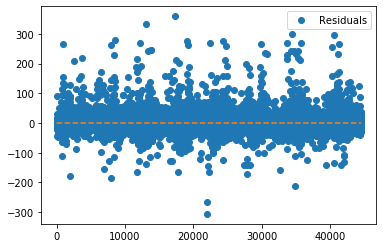

18.456053648214468


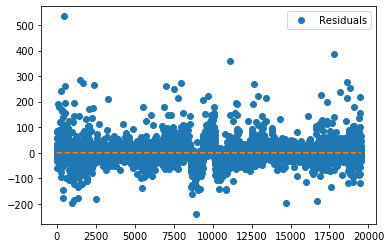

23.541771510707466


In [242]:
gb_reg_best = clf_gb.best_estimator_
gb_reg_best.fit(X_train, y_train.values.reshape(-1))
print(np.sqrt(score(y_train.values.reshape(-1), gb_reg_best.predict(X_train), mean_squared_error, plot_residuals=True)))
print(np.sqrt(score(y_test.values.reshape(-1), gb_reg_best.predict(X_test), mean_squared_error, plot_residuals=True)))

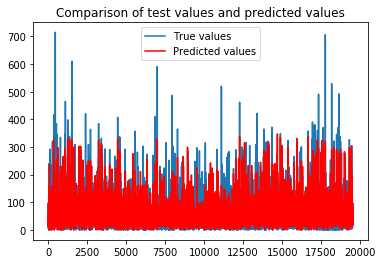

In [244]:
plt.plot(y_test.values, label='True values')
plt.plot(gb_reg_best.predict(X_test), color='r', label='Predicted values')
plt.title('Comparison of test values and predicted values')
plt.legend()
plt.show()

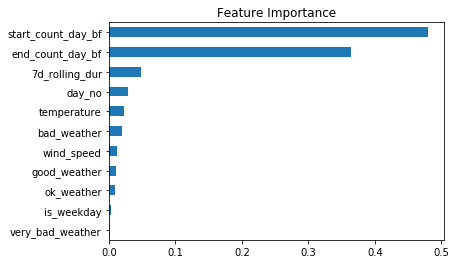

In [266]:
pd.DataFrame(gb_reg_best.feature_importances_, index=X_train.columns).sort_values(by=0).plot(kind='barh', legend=False, 
                                                                                             title='Feature Importance')
plt.show()

<b>There is some slight improvement using Gradient Boosting but the model still does not predict the peaks very well. We will follow up by using XGBoost (Extreme Gradient Boosting) which performs faster and introduces regularization which can help with overfitting.

#### XGBoost

In [10]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [21]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', subsample=0.8, colsample_bytree=0.8,
                          learning_rate=0.05)
param_test = {'n_estimators':range(20,81,10), 'max_depth':[3, 5, 8], 'min_child_weight':range(1,6,2), 'gamma':[0.5, 1, 2]}
clf_xgb = GridSearchCV(xgb_reg, param_test, cv=idx, scoring=make_scorer(rmse, greater_is_better=False))
clf_xgb.fit(X_train.values, y_train.values.reshape(-1))

GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [9372, 9373, 9374, 9375, 9376, 9377, 9378, 9379, 9380, 9381,
                   9382, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391,
                   9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, ...]),
                 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [1...
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=0.8, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0.5, 1, 2], 'max_depth': [3, 5, 8],
                         'min_child_weight': range(1, 6, 2),
                         'n_es

In [24]:
clf_xgb.best_params_

{'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 80}

In [33]:
xgb_reg_2 = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', learning_rate=0.05, gamma=0.5, max_depth=3, 
                             min_child_weight=5, n_estimators=80)
param_test = {'subsample':[0.6, 0.7, 0.8, 0.9], 'colsample_bytree':[0.6, 0.7, 0.8, 0.9]}
clf_xgb_2 = GridSearchCV(xgb_reg_2, param_test, cv=idx, scoring=make_scorer(rmse, greater_is_better=False))
clf_xgb_2.fit(X_train.values, y_train.values.reshape(-1))

GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [9372, 9373, 9374, 9375, 9376, 9377, 9378, 9379, 9380, 9381,
                   9382, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391,
                   9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, ...]),
                 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [1...
                                    nthread=None, objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                 

In [34]:
clf_xgb_2.best_params_

{'colsample_bytree': 0.8, 'subsample': 0.6}

In [48]:
xgb_reg_3 = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', learning_rate=0.05, gamma=0.5, max_depth=3, 
                             min_child_weight=5, n_estimators=80, colsample_bytree=0.8, subsample=0.6)
param_test = {'reg_alpha': [0.01, 0.1, 1, 100]}
clf_xgb_3 = GridSearchCV(xgb_reg_3, param_test, cv=idx, scoring=make_scorer(rmse, greater_is_better=False))
clf_xgb_3.fit(X_train.values, y_train.values.reshape(-1))

GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [9372, 9373, 9374, 9375, 9376, 9377, 9378, 9379, 9380, 9381,
                   9382, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391,
                   9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, ...]),
                 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [1...
                                    missing=None, n_estimators=80, n_jobs=1,
                                    nthread=None, objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=0.6, verbosity=1),
             iid='warn', n_jobs=None,
     

In [49]:
clf_xgb_3.best_params_

{'reg_alpha': 0.01}

In [58]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', learning_rate=0.05, gamma=0.5, max_depth=3, 
                             min_child_weight=5, n_estimators=80, colsample_bytree=0.8, subsample=0.6, reg_alpha=0.01)

xgb_param = xgb_reg.get_xgb_params()
xgdata = xgb.DMatrix(X_train, label=y_train)
cvresult = xgb.cv(xgb_param, xgdata, num_boost_round=xgb_reg.get_params()['n_estimators'], folds=idx,
            metrics='rmse', early_stopping_rounds=50)
xgb_reg.set_params(n_estimators=cvresult.shape[0])

xgb_reg.fit(X_train, y_train, eval_metric='rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='rmse',
             gamma=0.5, importance_type='gain', learning_rate=0.05,
             max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
             n_estimators=80, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0.01,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.6, verbosity=1)

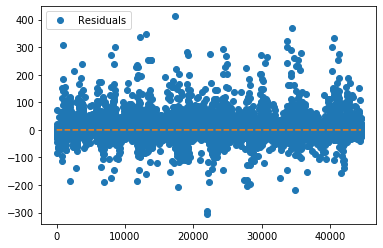

20.874047849351207


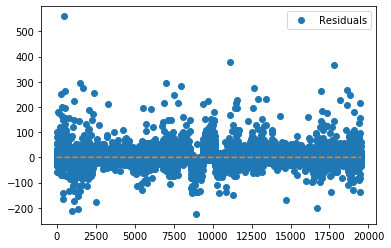

23.533453424194555


In [59]:
print(np.sqrt(score(y_train.values.reshape(-1), xgb_reg.predict(X_train), mean_squared_error, plot_residuals=True)))
print(np.sqrt(score(y_test.values.reshape(-1), xgb_reg.predict(X_test), mean_squared_error, plot_residuals=True)))

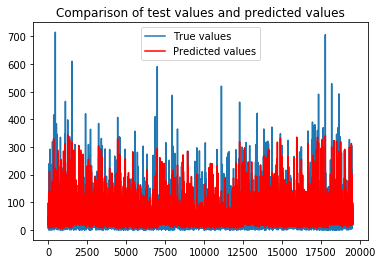

In [60]:
plt.plot(y_test.values, label='True values')
plt.plot(xgb_reg.predict(X_test), color='r', label='Predicted values')
plt.title('Comparison of test values and predicted values')
plt.legend()
plt.show()

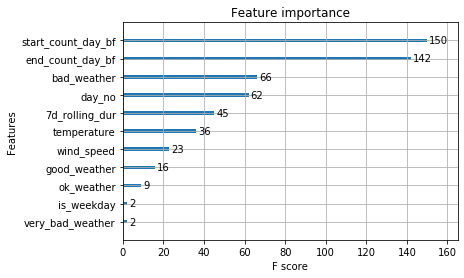

In [62]:
xgb.plot_importance(xgb_reg)
plt.show()

<b>Not much improvement using XGBoost but this model will be less prone to overfitting. We will try one last boosting method, AdaBoost.

#### AdaBoost

In [65]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [77]:
base_model = DecisionTreeRegressor(max_features='sqrt')
agb = AdaBoostRegressor(base_estimator=base_model)
param_test = {'base_estimator__max_depth': [3, 5, 8], 'base_estimator__min_samples_split':[50, 100, 250, 500], 
              'base_estimator__min_samples_leaf':range(30,71,20), 'learning_rate':[0.01, 0.05, 0.1], 
              'n_estimators':range(50,81,10)}
clf_agb = GridSearchCV(agb, param_test, cv=idx, scoring=make_scorer(rmse, greater_is_better=False))
clf_agb.fit(X_train.values, y_train.values.reshape(-1))

GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [9372, 9373, 9374, 9375, 9376, 9377, 9378, 9379, 9380, 9381,
                   9382, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391,
                   9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, ...]),
                 ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [1...
             iid='warn', n_jobs=None,
             param_grid={'base_estimator__max_depth': [3, 5, 8],
                         'base_estimator__min_samples_leaf': range(30, 71, 20),
                         'base_estimator__min_samples_split': [50, 100, 250,
                                                               500],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'n_estima

In [101]:
agb_best = clf_agb.best_estimator_
clf_agb.best_params_

{'base_estimator__max_depth': 8,
 'base_estimator__min_samples_leaf': 30,
 'base_estimator__min_samples_split': 50,
 'learning_rate': 0.01,
 'n_estimators': 70}

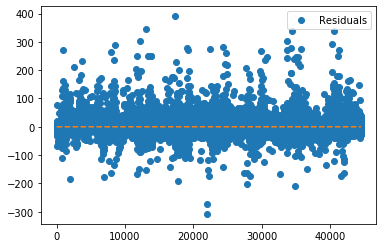

20.07724470762675


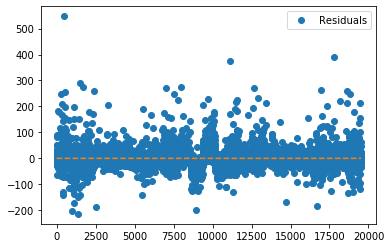

23.238190699448804


In [102]:
agb_best.fit(X_train, y_train.values.reshape(-1))
print(np.sqrt(score(y_train.values.reshape(-1), agb_best.predict(X_train), mean_squared_error, plot_residuals=True)))
print(np.sqrt(score(y_test.values.reshape(-1), agb_best.predict(X_test), mean_squared_error, plot_residuals=True)))

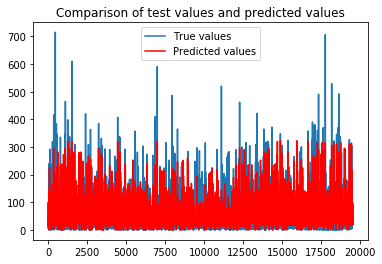

In [140]:
plt.plot(y_test.values, label='True values')
plt.plot(agb_best.predict(X_test), color='r', label='Predicted values')
plt.title('Comparison of test values and predicted values')
plt.legend()
plt.show()

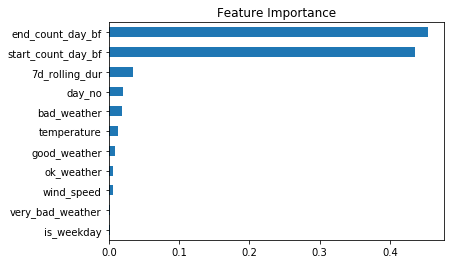

In [141]:
pd.DataFrame(agb_best.feature_importances_, index=X_train.columns).sort_values(by=0).plot(kind='barh', legend=False, 
                                                                                             title='Feature Importance')
plt.show()

<b>We see some more slight improvements using AdaBoost but overall the RMSE value remains at 23. We still have issues with the model's ability to predict the large peaks. Most of these peaks occur at the same few stations which are very popular. It might be useful to add aditional features with regards to station location or perform the analysis by station groups, where we group stations into different categories based on historical popularity. For example, it is possile that stations in Zone 1 and 2 are significantly more popular than those in other zones and stations near popular parks will also be more popular. 